In [1]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from utils import *
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

%matplotlib inline
cwd = os.getcwd()
input_dir = os.path.join(os.path.dirname(cwd), 'data', 'imgs')
TARGET_WIDTH = 600
TARGET_HEIGHT = 400
img_shape=(3, TARGET_HEIGHT, TARGET_WIDTH)
target_size = (TARGET_HEIGHT,TARGET_WIDTH)

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
% cd $cwd

/home/ubuntu/courses/deeplearning1/nbs/whale_recognition


# Setup

In [3]:
ann = pd.read_csv('bbox_600_400_.csv')

In [4]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/imgs'

In [5]:
tr_b = ImageDataGenerator().flow_from_directory(input_dir+'/train',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 3862 images belonging to 1 classes.


In [6]:
val_b = ImageDataGenerator().flow_from_directory(input_dir+'/valid',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 682 images belonging to 1 classes.


In [7]:
tr_files = tr_b.filenames

In [8]:
val_files = val_b.filenames

In [33]:
tr_data = np.concatenate([tr_b.next() for i in range(tr_b.nb_sample)])

In [34]:
tr_data.shape

(3862, 3, 400, 600)

In [35]:
val_data = np.concatenate([val_b.next() for i in range(val_b.nb_sample)])

In [36]:
val_data.shape

(682, 3, 400, 600)

In [9]:
tr_files= [f[f.find('/')+1:] for f in tr_b.filenames]

In [10]:
val_files = [f[f.find('/')+1:] for f in val_b.filenames]

In [11]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [12]:
val_ann = ann[ann.Image.isin(val_files)]

In [13]:
val_ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,232.835803,198.918777,122.834636,93.500992
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,292.325754,192.271040,65.934673,69.623326
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,274.804652,125.875285,85.761183,105.126612
7,w_825.jpg,whale_33152,545.330467,590.184488,3504,2336,1534.479668,864.030090,w_825.jpg,2033.228315,966.540379,1707.166500,1108.610169,262.753368,147.950358,101.058988,93.378505
11,w_3909.jpg,whale_06069,460.343900,632.677771,3072,2048,1397.556867,887.637469,w_3909.jpg,1925.487537,1157.742772,1678.420738,1031.146560,272.960326,173.366693,123.569877,89.910918


In [14]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    w = r.width_new.values[0]
    h = r.height_new.values[0]
    x = r.bboxx_new.values[0]
    y = r.bboxy_new.values[0]
    tr_y.append([w,h,x,y])

val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    w = r.width_new.values[0]
    h = r.height_new.values[0]
    x = r.bboxx_new.values[0]
    y = r.bboxy_new.values[0]
    val_y.append([w,h,x,y])

tr_y = np.array(tr_y)

val_y = np.array(val_y)

In [15]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[0], bb[1], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_y[i]
    plot(val_data[i])
    plt.gca().add_patch(create_rect(bb))

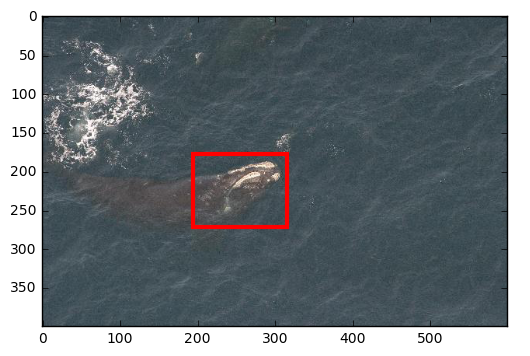

In [45]:
show_bb(232)

In [22]:
def check_smaller(names, bboxes, sub_dir):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    bbox = bboxes[idx,:]    
    
    f_name =os.path.join(input_dir, sub_dir, f)
    img = Image.open(f_name)
    img_arr = np.array(img, dtype=np.uint8)
    print(img_arr.shape)
    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
    rect = patches.Rectangle((bbox[2],bbox[3] ),
                             bbox[0],
                             bbox[1], 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    print(f)
    plt.show()



1895
(268, 300, 3)
w_3376.jpg


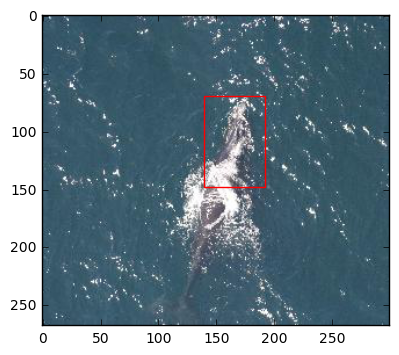

In [35]:
check_smaller(tr_files, tr_y, 'train/wrap')

210
(268, 300, 3)
w_7777.jpg


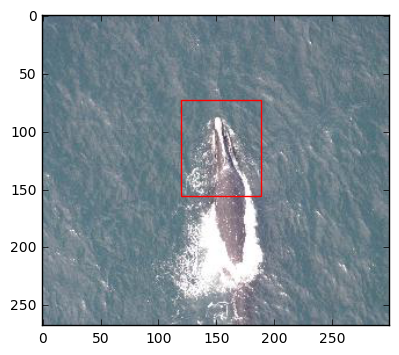

In [41]:
check_smaller(val_files, val_y, 'valid/wrap')

# Vgg Model

In [46]:
import vgg16bn

In [47]:
vgg = Vgg16BN(size=target_size, include_top=False)

In [48]:
model = vgg.model

In [49]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 400, 600)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 402, 602)   0           lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 400, 600)  1792        zeropadding2d_14[0][0]           
____________________________________________________________________________________________________
zeropadding2d_15 (ZeroPadding2D) (None, 64, 402, 602)  0           convolution2d_14[0][0]           
___________________________________________________________________________________________

In [50]:
for l  in model.layers: l.trainable = False

In [51]:
tr_conv_f = model.predict(tr_data)

In [53]:
tr_conv_f.shape

(3862, 512, 12, 18)

In [58]:
save_array('vggbb_600_400_conv_feat_train.bc', tr_conv_f)

In [55]:
val_conv_f = model.predict(val_data)

In [56]:
val_conv_f.shape

(682, 512, 12, 18)

In [59]:
save_array('vggbb_600_400_conv_feat_val.bc', val_conv_f)

In [16]:
tr_f = load_array('vggbb_600_400_conv_feat_train.bc')

In [17]:
val_f = load_array('vggbb_600_400_conv_feat_val.bc')

In [9]:
def get_lm():
    return Sequential([
            Flatten(input_shape=(512,12,18)),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.),
            Dense(512, activation='relu'),
            BatchNormalization(),
            Dropout(0.),
            Dense(4, activation='linear')
        ])

In [20]:
lm = get_lm()

In [21]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [22]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=5)

Train on 3862 samples, validate on 682 samples
Epoch 1/5
3862/3862 [==============================] - 6s - loss: 26264.8219 - acc: 0.4480 - val_loss: 24454.0598 - val_acc: 0.4399
Epoch 2/5
3862/3862 [==============================] - 6s - loss: 18734.7210 - acc: 0.5026 - val_loss: 12898.0695 - val_acc: 0.5103
Epoch 3/5
3862/3862 [==============================] - 6s - loss: 8128.4348 - acc: 0.5774 - val_loss: 4712.2843 - val_acc: 0.6364
Epoch 4/5
3862/3862 [==============================] - 6s - loss: 2466.0983 - acc: 0.7328 - val_loss: 1597.6202 - val_acc: 0.8314
Epoch 5/5
3862/3862 [==============================] - 6s - loss: 690.2467 - acc: 0.8625 - val_loss: 680.0652 - val_acc: 0.9120


In [23]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 255.8256 - acc: 0.9254 - val_loss: 556.9520 - val_acc: 0.9487


In [24]:
lm.save_weights('bb_600_400_556.h5')

In [25]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 164.8617 - acc: 0.9557 - val_loss: 538.3087 - val_acc: 0.9413


In [26]:
lm.save_weights('bb_600_400_538.h5')

In [27]:
lm.optimizer.lr = 0.0001

In [28]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 129.9115 - acc: 0.9596 - val_loss: 534.1480 - val_acc: 0.9487


In [29]:
lm.save_weights('bb_600_400_534.h5')

In [30]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 116.4828 - acc: 0.9663 - val_loss: 534.7901 - val_acc: 0.9428


In [31]:
lm.optimizer.lr = 0.00001

In [32]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 107.4749 - acc: 0.9676 - val_loss: 521.3853 - val_acc: 0.9472


In [33]:
lm.save_weights('bb_600_400_521.h5')

In [34]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 102.6016 - acc: 0.9627 - val_loss: 531.9778 - val_acc: 0.9457


In [35]:
lm.fit(tr_f, tr_y, validation_data=(val_f, val_y), shuffle=True, nb_epoch=1)

Train on 3862 samples, validate on 682 samples
Epoch 1/1
3862/3862 [==============================] - 7s - loss: 100.3520 - acc: 0.9601 - val_loss: 539.9107 - val_acc: 0.9443


In [41]:
lm.load_weights('bb_600_400_521.h5')

In [44]:
val_preds = lm.predict(val_f)

In [45]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[0], bb[1], color=color, fill=False, lw=3)

def show_bb_pred(i):
    bb = val_preds[i]
    plot(val_data[i])
    plt.gca().add_patch(create_rect(bb))
    
    
def show_bb_gt(i):
    bb = val_y[i]
    plot(val_data[i])
    plt.gca().add_patch(create_rect(bb, 'yellow'))

In [46]:
mse = np.sum((val_ann[['width_new', 'height_new', 'bboxx_new', 'bboxy_new']].values - val_preds)**2, axis=1)

In [47]:
mse_idx = np.argsort(mse)[::-1]

In [48]:
mse_idx[:10]

array([ 71, 168, 465, 567, 353, 608, 520, 528, 548, 346])

In [49]:
def compareBoxes(idx):
    show_bb_pred(idx)
    show_bb_gt(idx)

In [216]:
msexy = np.sum((val_ann[['bboxx_new', 'bboxy_new']].values - val_preds[:, 2:])**2, axis=1)

In [217]:
msexy_idx = np.argsort(msexy)[::-1]

In [218]:
msexy_idx[:10]

array([ 71, 168, 567, 608, 465, 520,  34, 528, 353, 283])

# Predictions

In [3]:
test_b = ImageDataGenerator().flow_from_directory(input_dir+'/test',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=32,
                                               class_mode=None)

Found 6925 images belonging to 1 classes.


In [4]:
test_files = test_b.filenames

In [5]:
vgg = Vgg16BN(size=target_size, include_top=False)

In [6]:
model = vgg.model

In [7]:
for l  in model.layers: l.trainable = False

In [8]:
test_conv_f = model.predict_generator(test_b, val_samples=test_b.nb_sample)

In [10]:
test_conv_f.shape

(6925, 512, 12, 18)

In [13]:
save_array('vggbb_600_400_test_conv_feat.bc', test_conv_f)

In [12]:
lm = get_lm()

In [14]:
lm.load_weights('bb_600_400_521.h5')

In [15]:
lm.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [16]:
test_p = lm.predict(test_conv_f)

In [17]:
test_files = [f[f.find('/') + 1:] for f in test_files]

In [18]:
test_data =np.hstack((np.array(test_files)[:, np.newaxis], test_p))

In [19]:
testdf = pd.DataFrame(test_data, columns=['Image', 'w', 'h', 'x', 'y'])

In [20]:
testdf.head()

,Image,w,h,x,y
0,w_8037.jpg,96.7061386108,108.894378662,232.960708618,194.290939331
1,w_4494.jpg,80.1549606323,81.8348312378,232.537826538,99.2113342285
2,w_4673.jpg,114.023788452,85.8122253418,237.209884644,167.134124756
3,w_8273.jpg,103.140838623,73.8779678345,271.808258057,130.176422119
4,w_7611.jpg,109.106262207,112.219261169,321.994018555,140.577163696


486
(400, 600, 3)
w_9124.jpg


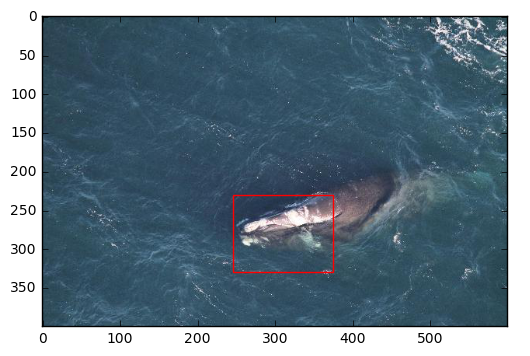

In [47]:
check_smaller(testdf.Image.values, testdf[['w', 'h', 'x', 'y']].values, 'test/unknown')

In [357]:
len(testdf)

6925

In [49]:
testdf.to_csv('test_bb_ann_600_400.csv', index=False)